<div style="text-align: center;">
    <h1>Textual <strike>Semantic</strike> Similarity Analysis <br/>between Embeddings Techniques <br/> using Brazilian Legal Data</h1>
<div>

# Introdução

No contexto Legal, a recuperação de decisões anteriores sobre um assunto de interesse é utilizada como precedente e serve como argumentação e como base de decisão sobre uma nova peça jurídica do mesmo assunto.
Devido ao grande número de registros jurídicos, o uso de técnicas computacionais se fazem indispensáveis para a varredura de toda uma base de dados de modo a retornar itens de uma pesquisa em tempo satisfatório.

A busca baseada em palavras chaves é muito utilizada na área de Recuperação da Informação. Entre as técnicas utilizadas na busca por palavras chaves, o <i>Bag of Words</i> e o <i>TF-IDF</i> são as comuns. Essas técnicas geram uma abstração onde o texto tem sua forma simbólica representada numericamente de forma a tornar possível a comparação e cálculo de similaridade com diferentes textos.

Outras técnicas de representações textuais que geram as representações codificando também a semântica envolvida surgiram para diferentes níveis de segmentação textual, como palavras, parágrafos ou textos completos. Com isso, um mesmo texto pode ser representado numericamente de formas diferentes.

# Objetivo
O objetivo deste estudo é analisar as convergências e divergências entre representações textuais geradas por diferentes técnicas de embeddings. Para isso, será analisado quais documentos são recuperados por cada técnica dada um documento de consulta. Feito isso, será realizada uma comparação entre as recuperações entre diferentes representações para uma mesma consulta.

# Dados
Os dados utilizados serão textos de acórdãos do STJ e votos do TCU. Os dados foram recuperados por uma rotina de raspagem de dados dos sites dos respectivos órgãos. A particularidade desses dados consiste em serem <b>precedentes de jurisprudências</b> usadas pelos órgãos. Jurisprudências são entendimentos adotados por órgãos jurídicos que orientam qual deve ser a decisão para um determinado assunto. Esses entendimentos são formulados a partir da análise de decisões anteriores sobre o mesmo assunto, e tem como objetivo uniformizar as decisões e dar celeridade aos processos de assuntos recorrentes.

O total dos dados obtidos com o procedimento de raspagem é o seguinte:

In [1]:
import pandas as pd
import re

def replace_edicao(text):
    s = re.sub("^EDIÇÃO N\. \d+:", "", text).strip()
    s = re.sub(" - M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$","", s)
    s = re.sub(" M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$","", s)
    
    return s

stj_data = pd.read_csv('../datasets/jurisprudencias_stj.csv', index_col=0)

#PRÉPROCESSAMENTO para remover textos que não deveriam estar nas colunas
stj_data['PROCESSO'] = stj_data['PROCESSO'].apply(lambda x: re.sub('Processo\n','',x))
stj_data['RELATOR'] = stj_data['RELATOR'].apply(lambda x: re.sub('Relator(a)\n','',x))
stj_data['ORGAO'] = stj_data['ORGAO'].apply(lambda x: re.sub('Órgão Julgador\n','',x))
stj_data['DATA_JULGAMENTO'] = stj_data['DATA_JULGAMENTO'].apply(lambda x: re.sub('Data do Julgamento\n','',x))
stj_data['DATA_PUBLICACAO'] = stj_data['DATA_PUBLICACAO'].apply(lambda x: re.sub('Data da Publicação/Fonte\nDJe','',x))
stj_data['EMENTA'] = stj_data['EMENTA'].apply(lambda x: re.sub('Ementa\n','',x))

stj_data.NATUREZA = stj_data.NATUREZA.map(replace_edicao)

tcu_data = pd.read_csv("../datasets/jurisprudencias_tcu.csv", index_col=0)

STJ: 
7407 Acórdãos
1458 Jurisprudências
7 Matérias
68 Naturezas

Histograma precedentes por Jurisprudência: 


<AxesSubplot:>

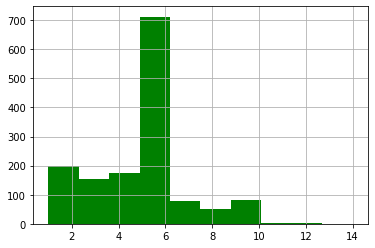

In [2]:
print("STJ: ")
print(len(stj_data), "Acórdãos")
print(len(stj_data.TEMA.unique()), "Jurisprudências")
print(len(stj_data.MATERIA.unique()), "Matérias")
print(len(stj_data.NATUREZA.unique()), "Naturezas\n")
print("Histograma precedentes por Jurisprudência: ")
stj_data.TEMA.value_counts().hist(color='green')

TCU: 
441 Acórdãos
44 Jurisprudências
4 Áreas
27 Temas
38 Subtemas

Histograma precedentes por Jurisprudência: 


<AxesSubplot:>

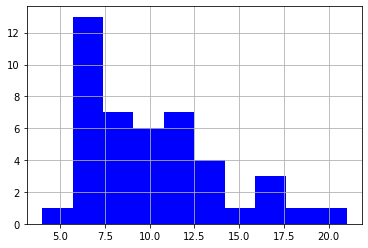

In [3]:
print("TCU: ")
print(len(tcu_data), "Acórdãos")
print(len(tcu_data.ENUNCIADO.unique()), "Jurisprudências")
print(len(tcu_data.AREA.unique()), "Áreas")
print(len(tcu_data.TEMA.unique()), "Temas")
print(len(tcu_data.SUBTEMA.unique()), "Subtemas\n")
print("Histograma precedentes por Jurisprudência: ")
tcu_data.ENUNCIADO.value_counts().hist(color='blue')

No entanto, durante o processo de raspagem alguns registros tiveram colunas nulas, e em alguns casos houve duplicação de registros. Analisando os histogramas abaixo é possível notar um outlier nos dados do TCU, indicado por documento com quantidade de palavras muito superior aos demais documentos.

In [4]:
stj_data = stj_data.dropna().drop_duplicates()
# stj_data = stj_data[stj_data.groupby(['TEMA'])['EMENTA'].transform('count') > 5]
tcu_data = tcu_data.dropna().drop_duplicates()

Text(0.5, 1.0, 'comparing number of words per sentence distribution in TCU data')

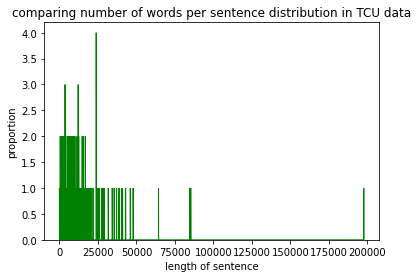

In [5]:
from matplotlib import pyplot as plt

tamanho_votos = [len(doc.split(' ')) for doc in tcu_data.VOTO]

plt.hist(tamanho_votos, bins=range(min(tamanho_votos), max(tamanho_votos) + 1, 1), 
         histtype='step', color="green")
plt.xlabel("length of sentence")
plt.ylabel("proportion")
plt.title("comparing number of words per sentence distribution in TCU data")

In [6]:
outliers = [i for i, d in tcu_data.iterrows() if len(d.VOTO.split(' ')) > 100000]
final_tcu_data = None
for i in outliers:
    final_tcu_data = tcu_data.drop(i)
tcu_data = final_tcu_data

Text(0.5, 1.0, 'comparing number of words per sentence distribution in STJ data')

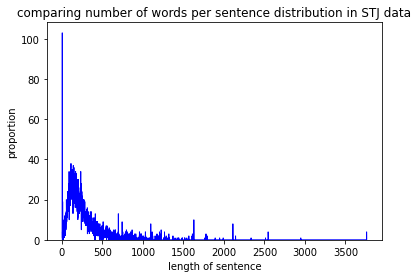

In [7]:
tamanho_acordaos = [len(doc.split(' ')) for doc in stj_data.EMENTA]

plt.hist(tamanho_acordaos, bins=range(min(tamanho_acordaos), max(tamanho_acordaos) + 1, 1), 
         histtype='step', color="blue")
plt.xlabel("length of sentence")
plt.ylabel("proportion")
plt.title("comparing number of words per sentence distribution in STJ data")

STJ: 
7403 Acórdãos
1458 Jurisprudências
7 Matérias
68 Naturezas

Histograma precedentes por Jurisprudência: 


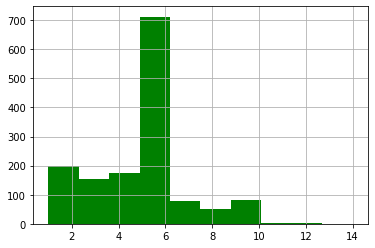

In [8]:
print("STJ: ")
print(len(stj_data), "Acórdãos")
print(len(stj_data.TEMA.unique()), "Jurisprudências")
print(len(stj_data.MATERIA.unique()), "Matérias")
print(len(stj_data.NATUREZA.unique()), "Naturezas\n")
print("Histograma precedentes por Jurisprudência: ")
stj_data.TEMA.value_counts().hist(color='green')
stj_data.to_csv('../datasets/jurisprudencias_stj_final.csv', index=False)

TCU: 
371 Acórdãos
44 Jurisprudências
4 Áreas
27 Temas
38 Subtemas

Histograma precedentes por Jurisprudência: 


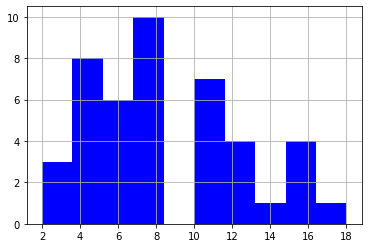

In [9]:
print("TCU: ")
print(len(tcu_data), "Acórdãos")
print(len(tcu_data.ENUNCIADO.unique()), "Jurisprudências")
print(len(tcu_data.AREA.unique()), "Áreas")
print(len(tcu_data.TEMA.unique()), "Temas")
print(len(tcu_data.SUBTEMA.unique()), "Subtemas\n")
print("Histograma precedentes por Jurisprudência: ")
tcu_data.ENUNCIADO.value_counts().hist(color='blue')
tcu_data.to_csv('../datasets/jurisprudencias_tcu_final.csv', index=False)

# Embeddings similarities analysis

Para este estudo foram escolhidas as seguintes técnicas:

<table>
    <thead>
        <tr>
            <th>Model</th>
            <th>Setup</th>
            <th>vector size</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>TF-IDF</td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td>BM25</td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td>word2vec</td>
            <td>mean</td>
            <td>300</td>
        </tr>
        <tr>
            <td>weighted word2vec</td>
            <td>TFIDF weighted + mean</td>
            <td>300</td>
        </tr>
        <tr>
            <td>fasttext</td>
            <td>mean</td>
            <td>300</td>
        </tr>
        <tr>
            <td>weighted fasttext</td>
            <td>TFIDF weighted + mean</td>
            <td>300</td>
        </tr>
        <tr>
            <td>Sentence Transformer</td>
            <td>Distill USE Multilingual</td>
            <td>512</td>
        </tr>
        <tr>
            <td>ELMo</td>
            <td>token embeddings mean</td>
            <td>1024</td>
        </tr>
        <tr>
            <td>BERT</td>
            <td>last 4 layers concat</td>
            <td>3072</td>
        </tr>
        <tr>
            <td>ITD BERT</td>
            <td>LM finetunned on ITD dataset, last 4 layers concat</td>
            <td>3072</td>
        </tr>
        <tr>
            <td>Longformer</td>
            <td>BERT based, last 4 layers concat</td>
            <td>3072</td>
        </tr>
        <tr>
            <td>ITD Longformer</td>
            <td>ITD BERT based, last 4 layers concat</td>
            <td>3072</td>
        </tr>
    </tbody>
</table>

O experimento consistiu em:
1) Gerar embedding para cada documento de cada conjunto de dados com cada uma das técnicas citadas
2) Recuperar os 5 documentos mais similares de cada documento do conjunto de dados com o auxílio do indexador Annoy e calcular a distância de cossenos entre as representações, exceto no caso do BM25 que tem uma dinâmica própria.
3) Salvar cada par de documentos similares de cada técnica em um arquivo CSV

O objetivo a partir daí é verificar as interseções dos pares de documentos similares gerados pelas diferentes técnicas. Para auxiliar na análise vamos usar a visualização <b>UpSet plots¹</b>.

A primeira análise será realizada a partir dos dados do TCU.

<p style='font-size:10px'>¹ Alexander Lex, Nils Gehlenborg, Hendrik Strobelt, Romain Vuillemot, Hanspeter Pfister, UpSet: Visualization of Intersecting Sets, IEEE Transactions on Visualization and Computer Graphics (InfoVis ‘14), vol. 20, no. 12, pp. 1983–1992, 2014. doi: doi.org/10.1109/TVCG.2014.2346248</p>


In [10]:
similarities = pd.read_csv("../results/tcu_similarities.csv", index_col=0)
models_dict = {}
for model_name, model_pairs in similarities.groupby("MODEL_NAME"):
    pairs = []
    for i, pair in model_pairs.iterrows():
        pairs.append((pair[0], pair[1]))
    models_dict[model_name] = set(pairs)

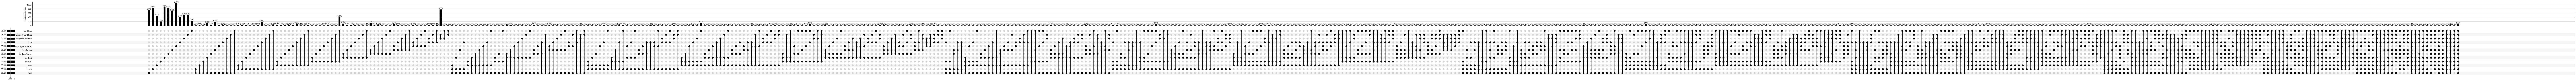

In [11]:
from matplotlib import pyplot
from upsetplot import from_contents, plot

example = from_contents(models_dict)
plot(
    example, show_percentages=True,
)
# orientation='vertical'
pyplot.show()
# pyplot.savefig("../results/tcu_similarities.png", bbox_inches="tight")

# Scatter plot with DensMAP Visualization

<b>DensMAP²</b> é uma técnica de redução de dimensionalidade para visualização de dados baseada no <b>UMAP³</b> que também se preocupa em criar espaços vetoriais reduzidos que respeitem de forma estimada a a densidade local das subpopulações dos dados a serem visualizados.


<p style='font-size:10px'>² NARAYAN, Ashwin; BERGER, Bonnie; CHO, Hyunghoon. Density-preserving data visualization unveils dynamic patterns of single-cell transcriptomic variability. bioRxiv, 2020.<p>
<p style='font-size:10px'>³ MCINNES, Leland; HEALY, John; MELVILLE, James. Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426, 2018.<p>

In [12]:
import os

import umap
from annoy import AnnoyIndex

vectors_size = {
    "tcu_tfidf.ann": 26322,
    "tcu_bert.ann": 3072,
    "tcu_elmo.ann": 1024,
    "tcu_word2vec.ann": 300,
    "tcu_weighted_word2vec.ann": 300,
    "tcu_fasttext.ann": 300,
    "tcu_weighted_fasttext.ann": 300,
    "tcu_itd_bert.ann": 3072,
    "tcu_longformer.ann": 3072,
    "tcu_itd_longformer.ann": 3072,
    "tcu_sentence_transformer.ann": 512,
}

data = {}
files = os.listdir("../results/")
for file in files:
    if file.endswith(".ann"):
        size = vectors_size[file.split("/")[-1]]
        ann = AnnoyIndex(size, "angular")
        ann.load("../results/" + file)  # super fast, will just mmap the file
        points = []
        for i in range(ann.get_n_items()):
            vec = ann.get_item_vector(i)
            #se eu usar um sample posso acabar tendo vetores vazios em alguns espaços do index
            result = len([elem for elem in vec if elem != 0])
            if result != 0:
                points.append(vec)
        
        points_embeddings = umap.UMAP(densmap=True, random_state=42). \
                                fit_transform(points)
        data[file.split("/")[-1]] = points_embeddings

In [34]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.palettes import Turbo256 

output_notebook()

tcu_data = pd.read_csv('../datasets/jurisprudencias_tcu_final.csv')
juris_enc = tcu_data.ENUNCIADO.astype('category').cat.codes.tolist()
juris_colors = [Turbo256[i*5] for i in juris_enc]


graph_data = [  {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_tfidf.ann', 'l2': 'TFIDF'},
                {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_word2vec.ann', 'l2': 'word2Vec'},
                {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_fasttext.ann', 'l2': 'FASTTEXT'},
                {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_elmo.ann', 'l2': 'ELMO'},
                {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_itd_bert.ann', 'l2': 'ITD-BERT'},
                {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_longformer.ann', 'l2': 'LONGFORMER'},
                {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_sentence_transformer.ann', 'l2': 'SENTENCE TRANSFORMER'},
                
             ]


for graph in graph_data:
    # create a column data source for the plots to share
    source = ColumnDataSource(data=dict(x0=data[graph['k1']][:, 0],x1=data[graph['k2']][:, 0], 
                                        y0=data[graph['k1']][:, 1], y1=data[graph['k2']][:, 1],
                                        jurisprudence=tcu_data.ENUNCIADO,index=tcu_data.index, color=juris_colors))

    TOOLS = "box_select,lasso_select,wheel_zoom,pan"

    plot_options = dict(width=500, plot_height=500, tools=TOOLS, tooltips="INDEX: @index \n JURISPRUDENCE: @jurisprudence")


    # create a new plot and add a renderer
    left = figure(**plot_options)
    left.circle('x0', 'y0', source=source, fill_color='color',line_color="white")
    left.title.text = graph['l1']
    left.title.align = "center"
    left.title.text_font_size = "20px"

    # left.title.text_color = "orange"
    # left.title.background_fill_color = "#aaaaee"

    # create another new plot and add a renderer
    right = figure(x_range=left.x_range, y_range=left.y_range, **plot_options)
    right.circle('x1', 'y1', source=source, fill_color='color',line_color="white")
    right.title.text = graph['l2']
    right.title.align = "center"
    right.title.text_font_size = "20px"

    p = gridplot([[left, right]])

    show(p)

Loading BokehJS ...

In [14]:
# import matplotlib.pyplot as plt

# %matplotlib inline

# def get_cmap(n, name='hsv'):
#     '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     RGB color; the keyword argument name must be a standard mpl colormap name.'''
#     return plt.cm.get_cmap(name, n)

# tcu_data = pd.read_csv('../datasets/jurisprudencias_tcu_final.csv')
# juris_enc = tcu_data.ENUNCIADO.astype('category').cat.codes.tolist()
# cmap = get_cmap(len(list(set(juris_enc))))
# juris_colors = [cmap(i) for i in juris_enc]

# for k, v in data.items():    
#     plt.scatter(v[:, 0], v[:, 1], 
#                 c=juris_colors, 
#                 marker=".", label=k)
# #     legend = plt.legend(loc=(1.04, 0))
#     legend = plt.legend(loc=(1.01, 0.9))
#     plt.show()



In [15]:
# graph_data = [  {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_tfidf.ann', 'l2': 'TFIDF'},
#                 {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_itd_bert.ann', 'l2': 'ITD-BERT'},
#                 {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_longformer.ann', 'l2': 'LONGFORMER'},
#                 {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_elmo.ann', 'l2': 'ELMO'},
#                 {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_sentence_transformer.ann', 'l2': 'SENTENCE TRANSFORMER'},
#                 {'k1': 'tcu_bert.ann', 'l1': 'BERT', 'k2': 'tcu_fasttext.ann', 'l2': 'FASTTEXT'}]


# for graph in graph_data:
#     plt.scatter(data[graph['k1']][:, 0], data[graph['k1']][:, 1], marker=".", label=graph['l1'])
#     plt.scatter(data[graph['k2']][:, 0], data[graph['k2']][:, 1], marker="+", label=graph['l2'])
#     plt.legend(loc=(1.01, 0.85))
#     plt.show()

# Semantic Textual Similarity Dataset

A partir dos dados de jurisprudências de cada órgão foi gerado um conjunto de dados para a tarefa de STS. A premissa utilizada para a construção do conjunto de dados foi que acórdãos/votos de uma mesma jurisprudência guardam uma grande relação de similaridade. Ainda, metadados como matéria, natureza, ou tema dos textos de cada órgao também permitem inferir diferentes graus de similaridade entre textos distintos. Com isso, o conjunto de dados de STS gerado tem uma anotação fraca, pois os rótulos não foram produzidos por um anotador real, mas baseado em heurísticas provenientes dos metadados disponíveis.

In [16]:
tcu_sts = pd.read_csv("../datasets/tcu_sts.csv").drop_duplicates(
    subset=["sentence_A", "sentence_B"], keep="last"
)
stj_sts = pd.read_csv("../datasets/stj_sts.csv").drop_duplicates(
    subset=["sentence_A", "sentence_B"], keep="last"
)

In [17]:
print("Total de registros do TCU: ", len(tcu_sts))
print("Total de registros do STJ: ", len(stj_sts))

Total de registros do TCU:  4843
Total de registros do STJ:  51437


# How each embedding technique performs compared to STS dataset

In [18]:
import numpy as np

SOURCE_INDEX = 0
SIMILAR_INDEX = 1

sts_similarities = {}

for model, s_data in similarities.groupby("MODEL_NAME"):
    pairs_score = []
    for i, row in s_data.iterrows():
        sentence_A = tcu_data.iloc[row[SOURCE_INDEX]].VOTO
        sentence_B = tcu_data.iloc[row[SIMILAR_INDEX]].VOTO
        pair = tcu_sts[
            ((tcu_sts.sentence_A == sentence_A) & (tcu_sts.sentence_B == sentence_B))
            | ((tcu_sts.sentence_B == sentence_A) & (tcu_sts.sentence_A == sentence_B))
        ]
        if len(pair) > 0:
            pairs_score.append(pair.iloc[0].score)
        else:
            pairs_score.append(0)

    sts_similarities[model] = pairs_score

scores_stats = []
for model, scores in sts_similarities.items():
    similars = [x for x in sts_similarities[model] if x != 0]
    non_similars = [x for x in sts_similarities[model] if x == 0]
    scores_stats.append([model, len(similars), np.mean(similars), np.std(similars)])

Total de pares similares gerados por cada técnica:  1855




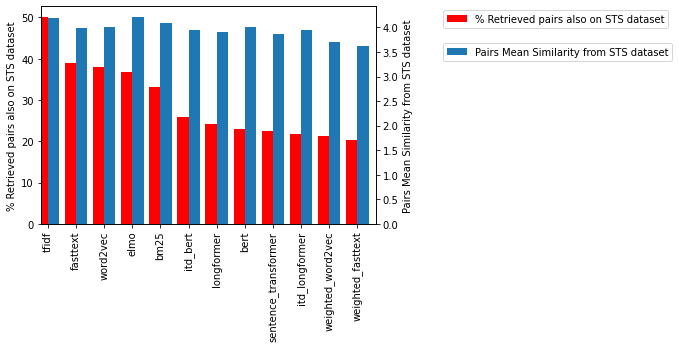

In [19]:
print(
    "Total de pares similares gerados por cada técnica: ", len(sts_similarities["bert"])
)
print("\n")
df = pd.DataFrame(scores_stats, columns=["MODEL", "SIMILAR_NUMBER", "MEAN_SIMILARITY", "STANDARD_DEVIATION"])
fig = pyplot.figure()  # Create matplotlib figure

ax = fig.add_subplot(111)  # Create matplotlib axes
ax2 = ax.twinx()  # Create another axes that shares the same x-axis as ax.

width = 0.4

df['SIMILARS_PERCENTUAL'] = (df.SIMILAR_NUMBER / len(sts_similarities["bert"]))*100
df_sorted = df.sort_values(by=['SIMILARS_PERCENTUAL'],ascending=False)
df_sorted.SIMILARS_PERCENTUAL.plot(kind="bar", color="red", ax=ax, width=width, position=1)
df_sorted.MEAN_SIMILARITY.plot(kind="bar", ax=ax2, width=width, position=0)

ax.set_ylabel("% Retrieved pairs also on STS dataset")
ax2.set_ylabel("Pairs Mean Similarity from STS dataset")

ax.set_xticklabels(df_sorted.MODEL)

ax.legend(["% Retrieved pairs also on STS dataset"], loc=(1.2, 0.9))
ax2.legend(["Pairs Mean Similarity from STS dataset"], loc=(1.2, 0.75))
# fig.tight_layout()
plt.show()
# df.sort_values(by=['MEAN_SIMILARITY'],ascending=False)

### Ponto 1:

- Calcular os mais similares de cada documento numa representação para documentos de outra representação (p.ex.: BERT -> Longformer) e analisar com o conjunto de similares calculados dentro de uma mesma representação.
    - Verificar médias e variâncias

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot
from upsetplot import from_contents, plot

lists_intersection = lambda l1, l2: [list(x) for x in set(tuple(x) for x in l1).intersection(set(tuple(x) for x in l2))]

def from_one_to_another_space_similarities(source_ann, target_ann, nns_in_source):
    to_another = []

    for i in range(bert_ann.get_n_items()):
        source_vector = source_ann.get_item_vector(i)
        #se eu usar um sample posso acabar tendo vetores vazios em alguns espaços do index
        result = len([elem for elem in vec if elem != 0])
        if result != 0:
            nns = target_ann.get_nns_by_vector(source_vector, 6, search_k=-1, include_distances=False)

            for similar_index in nns[1:]:
                similar_vector = source_ann.get_item_vector(similar_index)
                similarity = cosine_similarity([source_vector], [similar_vector])[0][0]
                to_another.append([i, similar_index, similarity, 'BERT'])

    to_another_df = pd.DataFrame(to_another, 
                            columns=['SOURCE_INDEX','SIMILAR_INDEX','COSINE_SIMILARITY','MODEL_NAME'])
    
    intersection = pd.merge(to_another_df, nns_in_source, how='inner', on=['SIMILAR_INDEX','SOURCE_INDEX'])
    print('Total de pares de vizinhos: ', len(nns_in_source))
    print('Tamanho da interseção de vizinhos entre diferentes representações:', len(intersection))
    print('Média da Similaridade de Cosseno entre os pares de vizinhos da interseção: ', np.mean(intersection.COSINE_SIMILARITY_x))
    print('Desvio Padrão da Similaridade de Cosseno entre os pares de vizinhos da interseção: ', np.std(intersection.COSINE_SIMILARITY_x))
    
    pairs = []
    spaces_comparision = {}
    for i, pair in to_another_df.iterrows():
        pairs.append((pair[0], pair[1]))
    spaces_comparision['R1 -> R2'] = set(pairs)

    pairs = []
    for i, pair in nns_in_source.iterrows():
        pairs.append((pair[0], pair[1]))
    spaces_comparision['R1->R1'] = set(pairs)

    example = from_contents(spaces_comparision)
    plot(example, show_percentages=True,)
    pyplot.show()
    print()

BERT -> LONGFORMER
Total de pares de vizinhos:  1855
Tamanho da interseção de vizinhos entre diferentes representações: 790
Média da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.9758266235848762
Desvio Padrão da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.010058526432770236


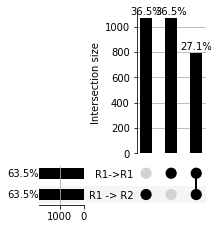


LONGFORMER -> BERT
Total de pares de vizinhos:  1855
Tamanho da interseção de vizinhos entre diferentes representações: 809
Média da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.9717539730373596
Desvio Padrão da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.01129039659541216


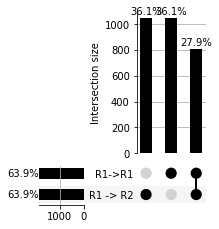


BERT -> ITD_BERT
Total de pares de vizinhos:  1855
Tamanho da interseção de vizinhos entre diferentes representações: 62
Média da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.977776953321972
Desvio Padrão da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.011506613175114222


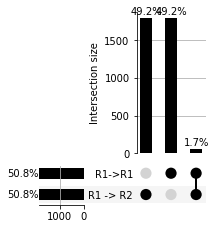


LONGFORMER -> ITD_LONGFORMER
Total de pares de vizinhos:  1855
Tamanho da interseção de vizinhos entre diferentes representações: 150
Média da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.9775441387944643
Desvio Padrão da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.014716103053325396


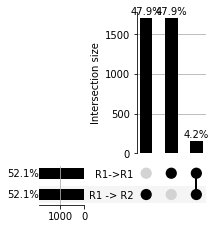


ITD_LONGFORMER -> LONGFORMER
Total de pares de vizinhos:  1855
Tamanho da interseção de vizinhos entre diferentes representações: 95
Média da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.9934178544842694
Desvio Padrão da Similaridade de Cosseno entre os pares de vizinhos da interseção:  0.004603031290777215


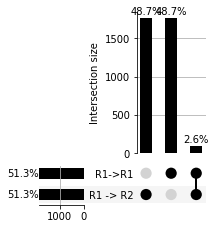

In [21]:
bert_ann = AnnoyIndex(3072, "angular")
bert_ann.load("../results/tcu_bert.ann")

itd_bert_ann = AnnoyIndex(3072, "angular")
itd_bert_ann.load("../results/tcu_itd_bert.ann")

long_ann = AnnoyIndex(3072, "angular")
long_ann.load("../results/tcu_longformer.ann")

itd_long_ann = AnnoyIndex(3072, "angular")
itd_long_ann.load("../results/tcu_itd_longformer.ann")

in_same_bert = similarities[similarities.MODEL_NAME == 'bert']
in_same_itd_bert = similarities[similarities.MODEL_NAME == 'itd_bert']
in_same_longformer = similarities[similarities.MODEL_NAME == 'longformer']
in_same_itd_longformer = similarities[similarities.MODEL_NAME == 'itd_longformer']

print('BERT -> LONGFORMER')
from_one_to_another_space_similarities(bert_ann, long_ann, in_same_bert)

print('LONGFORMER -> BERT')
from_one_to_another_space_similarities(long_ann, bert_ann, in_same_longformer)

print('BERT -> ITD_BERT')
from_one_to_another_space_similarities(bert_ann, itd_bert_ann, in_same_bert)

print('LONGFORMER -> ITD_LONGFORMER')
from_one_to_another_space_similarities(long_ann, itd_long_ann, in_same_longformer)

print('ITD_LONGFORMER -> LONGFORMER')
from_one_to_another_space_similarities(itd_long_ann, long_ann, in_same_itd_longformer)

### Ponto 2:
- Calcular a distância de um mesmo documento D1 entre duas representações diferentes (D1' -> D1'')
- Recuperar o documento mais próximo do D1 em uma das representação (D2) e calcular a distância.
    - O que é mais próximo: o mesmo documento em representações diferentes ou o mais próximo do documento em uma representação fixada?
        - Verificar média das distâncias e mediana

In [22]:
from autorank import autorank, plot_stats, create_report, latex_table

def inner_and_outer_space_similarity(source_ann, another_ann):
    between_spaces_results = []
    for i , row in tcu_data.iterrows():
        source_vector = source_ann.get_item_vector(i)
        source_nns_i = source_ann.get_nns_by_item(i, 2)[-1]
        source_nns = source_ann.get_item_vector(source_nns_i)
        source_similarity = cosine_similarity([source_vector], [source_nns])[0][0]

        source_another_space_vector = another_ann.get_item_vector(i)
        source_another_space_similarity = cosine_similarity([source_vector], [source_another_space_vector])[0][0]

        between_spaces_results.append([i,source_nns_i,source_similarity,
                                       source_another_space_similarity])

    between_spaces_results_df = pd.DataFrame(between_spaces_results, 
                                columns=['SOURCE_INDEX','SOURCE_NNS_INDEX','SOURCE_NNS_SIMILARITY',
                                         'SOURCE_IN_ANOTHER_SPACE_SIMILARITY'])

    print('Média da Similaridade de Cosseno entre um documento e seu vizinho mais próximo numa mesma representação:\n', np.mean(between_spaces_results_df.SOURCE_NNS_SIMILARITY))
    print('Desvio Padrão da Similaridade de Cosseno entre um documento e seu vizinho mais próximo numa mesma representação:\n', np.std(between_spaces_results_df.SOURCE_NNS_SIMILARITY))
    print('Média da Similaridade de Cosseno entre duas representações distintas de um mesmo documento:\n', np.mean(between_spaces_results_df.SOURCE_IN_ANOTHER_SPACE_SIMILARITY))
    print('Desvio Padrão da Similaridade de Cosseno entre duas representações distintas de um mesmo documento:\n', np.std(between_spaces_results_df.SOURCE_IN_ANOTHER_SPACE_SIMILARITY))
    print('\n')
    to_test = pd.DataFrame()
    to_test['SOURCE'] = between_spaces_results_df.SOURCE_NNS_SIMILARITY
    to_test['ANOTHER_SPACE'] = between_spaces_results_df.SOURCE_IN_ANOTHER_SPACE_SIMILARITY
    autorank_result = autorank(to_test, alpha=0.05, verbose=False)
    create_report(autorank_result)
    plot_stats(autorank_result)
    plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
print('BERT -> LongFormer')
inner_and_outer_space_similarity(bert_ann, long_ann)

BERT -> LongFormer
Média da Similaridade de Cosseno entre um documento e seu vizinho mais próximo numa mesma representação:
 0.9794059343860635
Desvio Padrão da Similaridade de Cosseno entre um documento e seu vizinho mais próximo numa mesma representação:
 0.011801007032184258
Média da Similaridade de Cosseno entre duas representações distintas de um mesmo documento:
 0.9864929666486099
Desvio Padrão da Similaridade de Cosseno entre duas representações distintas de um mesmo documento:
 0.005267757831663447


The statistical analysis was conducted for 2 populations with 371 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations ANOTHER_SPACE (p=0.000) and SOURCE (p=0.000). Therefore, we assume that not all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and both of them are not normal, we use 

/opt/conda/lib/python3.7/site-packages/autorank/autorank.py:331: UserWarning: No plot to visualize statistics for Wilcoxon test available. Doing nothing.
  warnings.warn('No plot to visualize statistics for Wilcoxon test available. Doing nothing.')


Tomando como origem o espaço vetorial do BERT e como comparativo o LONGFORMER, o resultado acima sugere que do ponto de vista estatístico a similaridade entre diferentes representações de um mesmo documento é maior que a similaridade entre o documento e seu vizinho mais próximo na mesma representação de forma significante.

In [24]:
print('BERT -> ITD_BERT')
inner_and_outer_space_similarity(bert_ann, itd_bert_ann)

BERT -> ITD_BERT
Média da Similaridade de Cosseno entre um documento e seu vizinho mais próximo numa mesma representação:
 0.9794059343860635
Desvio Padrão da Similaridade de Cosseno entre um documento e seu vizinho mais próximo numa mesma representação:
 0.011801007032184258
Média da Similaridade de Cosseno entre duas representações distintas de um mesmo documento:
 0.8359465616349254
Desvio Padrão da Similaridade de Cosseno entre duas representações distintas de um mesmo documento:
 0.012941693650827585


The statistical analysis was conducted for 2 populations with 371 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations SOURCE (p=0.000) and ANOTHER_SPACE (p=0.000). Therefore, we assume that not all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and both of them are not normal, we use Wi

/opt/conda/lib/python3.7/site-packages/autorank/autorank.py:331: UserWarning: No plot to visualize statistics for Wilcoxon test available. Doing nothing.
  warnings.warn('No plot to visualize statistics for Wilcoxon test available. Doing nothing.')


Comentário semelhante ao anterior vale para esse exemplo.

# TODO Reunião 10/03

- <s>Calcular os mais similares de cada documento numa representação para documentos de outra representação (p.ex.: BERT -> Longformer) e analisar com o conjunto de similares calculados dentro de uma mesma representação.</s>
    - <s>Verificar médias e desvio padrão</s>

- <s>Calcular a distância de um mesmo documento D1 entre duas representações diferentes (D1' -> D1'')</s>
    - <s>Recuperar o documento mais próximo do D1 em uma das representação (D2) e calcular a distância.</s>
    - <s>O que é mais próximo: o mesmo documento em representações diferentes ou o mais próximo do </s>documento em uma representação fixada?</s>
    - <s>Verificar média das distâncias e desvio padrão</s>

- <s>Colorir os pontos em cada representação de acordo com a jurisprudência associada</s>
    - <s>Os pontos agrupados são de uma mesma jurisprudência?</s>

- <s>Consigo verificar se os grupos de diferentes representações são compostos dos mesmos documentos?</s>

- <s>Existe alguma ferramenta que auxilie essa visualização de forma interativa?</s>
    
- Quantidade de tokens por documento segundo cada forma de tokenização
 

# Questões a serem respondidas

- O tamanho do contexto importa? Longformer >> BERT?
- Há uma grande diferença no cálculo de similaridade entre diferentes arquiteturas? BERT != ELMo
- A Language Model base importa muito? BERT (BERTimbau) != Sentence Transformer (Distill USE Multilingual)
- Como se diferem entre si as abordagens frequentistas, agrupamento de vetores e contextualizas (com trasformer ou não)
- _Aline: "Daniel, uma coisa que esqueci de perguntar ontem: quando o tamanho do seu documento é maior que a entrada do modelo (no caso dos transformers, em particular), o que você faz? Fiquei me perguntando se esses seriam os mais representativos do documento."_
    - _Daniel: "Aí isso depende do foco de um analista. Por exemplo, na maior parte desse documentos, o começo é um resumo de tudo que envolve o processo, do meio pro fim acaba sendo o julgamento em si. Numa visão mais ampla, o resumo é mais útil pra similaridade. Mas a similaridade num grão mais fino se valeria melhor do restante do documento. Seria como usar o começo dos textos fosse um filtro grosseiro, e o resto do documento um filtro bem específico."_